In [2]:
from google.colab import drive
drive.mount('/content/drive')





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import PIL.Image
import random
import concurrent.futures
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np
import PIL.Image
import cv2
import random



In [4]:
def img_to_patches(input_path:str) -> tuple:
    img = PIL.Image.open(fp=input_path)
    if(input_path[-3:] not in ['jpg', 'jpeg']):
        img = img.convert('RGB')
    if(img.size != (256,256)):
        img = img.resize((256,256))
    patch_size = 32
    grayscale_patches = []
    color_patches = []
    for i in range(0, img.height, patch_size):
        for j in range(0, img.width, patch_size):
            box = (j, i, j + patch_size, i + patch_size)
            patch = np.asarray(img.crop(box))
            grayscale_patch = cv2.cvtColor(patch, cv2.COLOR_RGB2GRAY)
            grayscale_patches.append(grayscale_patch.astype(np.int32))
            color_patches.append(patch)
    return grayscale_patches, color_patches

def get_l1(v):
    return np.sum(np.abs(v[:, :-1] - v[:, 1:]))

def get_l2(v):
    return np.sum(np.abs(v[:-1, :] - v[1:, :]))

def get_l3l4(v):
    l3 = np.sum(np.abs(v[:-1, :-1] - v[1:, 1:]))
    l4 = np.sum(np.abs(v[1:, :-1] - v[:-1, 1:]))
    return l3 + l4

def get_pixel_var_degree_for_patch(patch):
    l1 = get_l1(patch)
    l2 = get_l2(patch)
    l3l4 = get_l3l4(patch)
    return l1 + l2 + l3l4

def extract_rich_and_poor_textures(variance_values, patches):
    threshold = np.mean(variance_values)
    rich_patches = [patch for i, patch in enumerate(patches) if variance_values[i] >= threshold]
    poor_patches = [patch for i, patch in enumerate(patches) if variance_values[i] < threshold]
    return rich_patches, poor_patches


def get_complete_image(patches, coloured=True):
    random.shuffle(patches)
    while len(patches) < 64:
        patches += patches[:64 - len(patches)]
    grid = np.array(patches).reshape((8, 8, 32, 32, 3)) if coloured else np.array(patches).reshape((8, 8, 32, 32))
    rows = [np.concatenate(row_patches, axis=1) for row_patches in grid]
    complete_image = np.concatenate(rows, axis=0)
    return complete_image


def smash_n_reconstruct(input_path, coloured=True):
    grayscale_patches, color_patches = img_to_patches(input_path)
    pixel_var_degree = [get_pixel_var_degree_for_patch(patch) for patch in grayscale_patches]

    if coloured:
        rich_patches, poor_patches = extract_rich_and_poor_textures(pixel_var_degree, color_patches)
    else:
        rich_patches, poor_patches = extract_rich_and_poor_textures(pixel_var_degree, grayscale_patches)

    rich_texture = get_complete_image(rich_patches, coloured)
    poor_texture = get_complete_image(poor_patches, coloured)

    return rich_texture, poor_texture


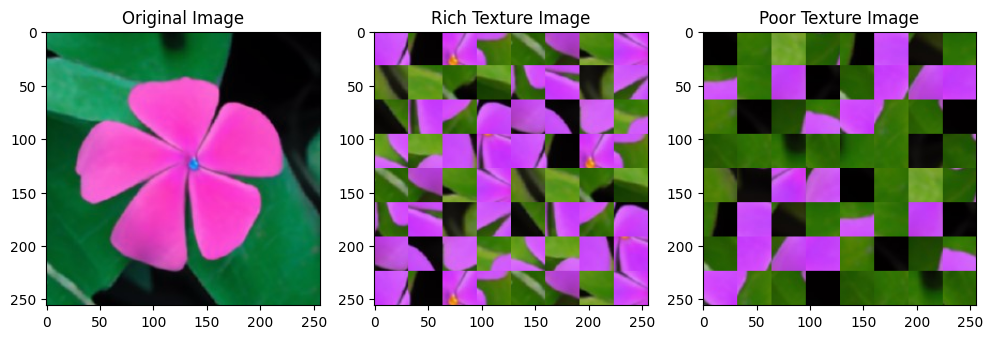

In [6]:
img_path = "/img1.jpeg"
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
rich_texture_img, poor_texture_img = smash_n_reconstruct(input_path= img_path)

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.subplot(1, 3, 2)
plt.imshow(rich_texture_img, cmap='gray')
plt.title('Rich Texture Image')
plt.subplot(1, 3, 3)
plt.imshow(poor_texture_img, cmap='gray')
plt.title('Poor Texture Image')
plt.show()

In [22]:
def preprocess_for_efficientnet(img):

    img = PIL.Image.fromarray(img)
    # Convert PIL Image to a NumPy array
    img_array = np.array(img)

    # Resize image to EfficientNet's expected size if not already
    if img_array.shape[:2] != (224, 224):
        img = img.resize((224, 224), PIL.Image.ANTIALIAS)
        img_array = np.array(img)

    # EfficientNet expects 3 color channels, convert if necessary
    if img_array.ndim == 2 or img_array.shape[2] == 1:
        img_array = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)

    # Add a batch dimension and preprocess
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    return img_array

In [23]:
preprocessed_rich_texture = preprocess_for_efficientnet(rich_texture_img)
preprocessed_poor_texture = preprocess_for_efficientnet(poor_texture_img)


<ipython-input-22-a2074eb68dd1>:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((224, 224), PIL.Image.ANTIALIAS)


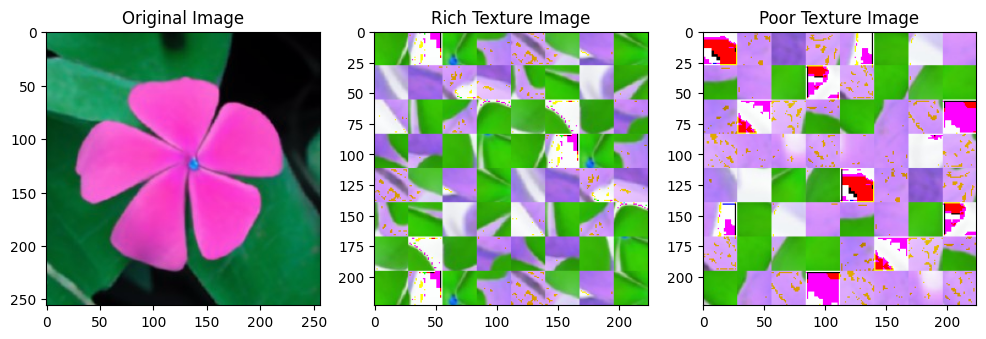

In [24]:
preprocessed_rich_texture_squeezed = preprocessed_rich_texture.squeeze()
preprocessed_poor_texture_squeezed = preprocessed_poor_texture.squeeze()

# Convert the image data from float32 in range [0, 1] to uint8 in range [0, 255]
rich_texture_display = (preprocessed_rich_texture_squeezed * 255).astype(np.uint8)
poor_texture_display = (preprocessed_poor_texture_squeezed * 255).astype(np.uint8)

# Plotting the images
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title('Original Image')

# Rich Texture Image (after removing batch dimension and scaling)
plt.subplot(1, 3, 2)
plt.imshow(rich_texture_display)
plt.title('Rich Texture Image')

# Poor Texture Image (after removing batch dimension and scaling)
plt.subplot(1, 3, 3)
plt.imshow(poor_texture_display)
plt.title('Poor Texture Image')

plt.show()